In [ ]:
!mkdir dataset


### data_downlaod.py

In [ ]:
import urllib.request
import zipfile
import os

dataset_url = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
text_url = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'


extract_dir = os.getcwd()

def download_unzip_url(url, extract_dir):
  zip_path, _ = urllib.request.urlretrieve(url)
  with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

if __name__ == '__main__':
  print('Downloading dataset - Flicker8k')
  download_unzip_url(dataset_url,'/content/dataset/images')
  print('Downloading text - Flicker8k')
  download_unzip_url(text_url, '/content/dataset/annot')


### dataset.py

In [ ]:
from collections import Counter
import torchtext
from torch.utils.data import Dataset
import torchvision.transforms as T
import pandas as pd
import torch
import cv2
import os

In [ ]:
def image_caption_dict(FILENAME, tokenizer):
    caption_map= {}
    corpus = []
    with open(FILENAME) as f:
        for line in f:
            line = line.rstrip('\n')
            line = line.rstrip(' .')
            img_name, caption = line.split('\t')

            img_name = img_name.split('.')[0] + '.jpg'

            if img_name == "2258277193_586949ec62.jpg":
                continue

            if img_name in caption_map.keys():
                caption_map[img_name] =caption_map[img_name] + [caption]
            else:
                caption_map[img_name] = [caption]
            corpus.append(caption)
    counter = Counter()
    for item in corpus:
        counter.update(tokenizer(item))
    vocab = torchtext.vocab.vocab(counter)

    for sp_token, index in zip(['<unk>', '<pad>', '<sos>', '<eos>'], [0,1,2,3]):
        vocab.insert_token(sp_token, index)
        vocab.set_default_index(0)

    dataframe = pd.DataFrame()
    dataframe = pd.DataFrame(columns=["image_filename", "captions"])
    dataframe["image_filename"] = caption_map.keys()
    dataframe["captions"] = dataframe["image_filename"].map(
        lambda x: caption_map[x]
    )
    return dataframe, vocab


class Image_caption_dataset(Dataset):
    def __init__(self, tokenizer, vocab, dataframe, seq_len):
        super().__init__()
        self.tokenizer = tokenizer
        self. dataframe = dataframe
        #self.img_size = img_size
        #EDIT
        self.seq_len = seq_len+1
        self.vocab = vocab
        self.transform = T.Compose([
            T.ToTensor(),
            T.Pad((150)),
            T.CenterCrop((400,400)),


        ])
        self.image_folder = os.path.join(os.getcwd(), 'dataset', 'images', 'Flicker8k_Dataset')

    def __getitem__(self, index):

        pad_idx = self.vocab["<pad>"]
        sos_idx = self.vocab["<sos>"]
        eos_idx = self.vocab["<eos>"]
        pad_starts = None
        if torch.is_tensor(index):
            index = index.item()
        image_name, caption_list = self.dataframe.iloc[index]
        image = cv2.imread(os.path.join(self.image_folder,image_name))
        tokens_array = []
        pad_ignore_mask= []
        for idx, e in enumerate(caption_list):
            tokens  = self.vocab(self.tokenizer(e))
            tokens = [sos_idx] + tokens +[eos_idx]

            if len(tokens) < self.seq_len:
                pad_starts = len(tokens)
                tokens = tokens + [pad_idx]*(self.seq_len - len(tokens))
            else:
                tokens = tokens[:self.seq_len-1] + [eos_idx]

            tokens_array.append(tokens)

            mask = torch.zeros(self.seq_len)
            if pad_starts is not None:
                mask[pad_starts:] = True
            pad_ignore_mask.append(mask)
        tokens_array = torch.LongTensor(tokens_array)
        pad_ignore_mask = torch.stack(pad_ignore_mask)

        assert image is not None, f'image empty {image_name}'
        assert tokens_array is not None, 'token empty'
        assert caption_list is not None, 'list empty'
        assert pad_ignore_mask is not None, 'mask empty'

        #EDIT

        out_dict = {
            "image": self.transform(image),
            "captions_tokens": tokens_array,
            "captions": caption_list,
            "pad_ignore_mask": pad_ignore_mask,
        }

        return out_dict

    def __len__(self):
        return len(self.dataframe)


### model.py

In [ ]:

import torch.nn as nn


class ImageCaptionGen(nn.Module):
    def __init__(self, img_size, cnn_backbone, vocab_len,  seq_len, d_model, n_decode, n_head, fc_dim, dropout):
        super().__init__()
        self.vocab_len= vocab_len
        self.seq_len = seq_len
        self.d_model = d_model
        self.img_size = img_size

        self.encoder = cnn_backbone
        for p in self.encoder.parameters():
            p.requires_grad = False

        self.embedding = nn.Embedding(self.vocab_len, self.d_model)
        dummy_img = torch.rand([3,img_size,img_size], requires_grad=False).unsqueeze(0) # shape [batch, channel, img_size, img_size]

        self.encoder_linear = nn.Linear(cnn_backbone(dummy_img).shape[1], self.d_model)  # [batch, cnn_out] -> [batch, d_model]

        self.embeddidng = nn.Embedding(vocab_len, d_model) # [batch, seq_len, 1] -> [batch, seq_len, d_model]
        self.pos_embedding = nn.Embedding(seq_len, d_model) # [batch, seq_len, 1] -> [batch, seq_len, d_model]
        #EDIT
        decoder_layer = nn.TransformerDecoderLayer(d_model, n_head, fc_dim, dropout, batch_first= True, norm_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, n_decode)

        self.linear = nn.Linear(d_model, vocab_len)
        #EDIT
        self.register_buffer('scale', torch.sqrt(torch.tensor([self.d_model])))
        #EDIT
        self.register_buffer('causal_mask', nn.Transformer.generate_square_subsequent_mask(self.seq_len))


    def forward(self, image, caption, ignore_pad_mask=None):
        #batch_size, seq_len = caption.shape[0], caption.shape[1]




        x = self.embeddidng(caption) * self.scale
        pos = self.pos_embedding(torch.zeros_like(caption).long())
        x= x + pos

        with torch.no_grad():
            image_rep = self.encoder(image)
        assert image_rep.dim() == 2, 'dimetions of image output not 2'
        image_rep = self.encoder_linear(image_rep) # [batch, encoder_out_dim] -> [batch_d_model]

        decoder_input = image_rep.unsqueeze(1) # [batch, d_model] -> [batch, 1, d_model] need for calculating the attention


        #EDIT
        x = self.decoder(x, decoder_input, tgt_mask = self.causal_mask, tgt_key_padding_mask = ignore_pad_mask) #[batch, seq_len, d_model]


        out = self.linear(x)
        return out



### train.py

In [ ]:
from torchtext.data import get_tokenizer

from torch.utils.data import DataLoader
import torchvision.models as models


import torch.optim as optim
from tqdm import tqdm

TRAIN_TEST_SPLIT = 0.8
#EDIT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet =  models.resnet50(weights= models.ResNet50_Weights.IMAGENET1K_V2)
resnet_backbone = torch.nn.Sequential(*(list(resnet.children())[:-1])+ [nn.Flatten()])



'''TEST_DATAFRAME = dataframe[int(len(dataframe)*TRAIN_TEST_SPLIT):]
TEST_DATASET = Image_caption_dataset(tokenizer, vocab, TEST_DATAFRAME, 32)
TEST_DATALOADER =  DataLoader(TEST_DATASET, 16, shuffle=True)
'''


def train(train_split=TRAIN_TEST_SPLIT, EPOCHS=1):
    tokenizer = get_tokenizer('basic_english')
    dataframe, vocab = image_caption_dict('dataset/annot/Flickr8k.token.txt', tokenizer)
    TRAIN_DATAFRAME = dataframe[:int(len(dataframe)*train_split)]
    TRAIN_DATASET = Image_caption_dataset(tokenizer, vocab, TRAIN_DATAFRAME, 32)
    TRAIN_DATALOADER = DataLoader(TRAIN_DATASET, 64, shuffle=False)

    model = ImageCaptionGen(img_size=400,cnn_backbone=resnet_backbone, vocab_len=len(vocab), seq_len=32, d_model=512, n_decode=2, n_head=8, fc_dim=1024,dropout= 0.1)
    #EDIT
    model.to(device)

    model.train()
    #EDIT
    print(f'-------------------compute is {device}------------------------')
    criterion =nn.CrossEntropyLoss()
    #EDIT
    optimizer = optim.Adam(model.parameters(), lr=0.000005)

    for epoch in range(EPOCHS):
        print("beginning epoch 1...")
        #EDIT
        batch_loader = tqdm(enumerate(TRAIN_DATALOADER), desc= 'begining batch training', postfix='current_loss = NA ')
        #EDIT
        for _, data in batch_loader:

            images = data['image'].to(device)
            #print('Image tensor shape: ', images.shape)
            tokens = data['captions_tokens']
            #print('Token tensor shape: ', tokens.shape)
            masks = data['pad_ignore_mask']
            #print('Mask tensor shape', masks.shape)

            tokens_sub_batches = torch.split(tokens, 1, 1)
            masks_sub_batches = torch.split(masks, 1, 1)

            avg_loss=0
            for sub_batch in range(len(tokens_sub_batches)):
              #EDIT
                batch_loader.set_description_str(f'Training sub-batch {epoch}--{_}--{sub_batch}->->->', refresh=True)
                #EDIT
                tokens_sub_batches_i = tokens_sub_batches[sub_batch].squeeze(1)[:, :-1].to(device)
                #EDIT
                masks_sub_batches_i = masks_sub_batches[sub_batch].squeeze(1)[:, :-1].to(device)

                pred = model(images, tokens_sub_batches_i, masks_sub_batches_i)
                #print("pred shape: ", pred.shape, type(pred))
                pred = pred.contiguous().view(-1, len(vocab))
                #print("reshaped pred shape: ", pred.shape)
                labels = tokens_sub_batches[sub_batch].squeeze(1)[:, 1:]
                #print('labels shape', labels.shape, type(labels))
                labels = labels.contiguous().view(-1).to(device)

                loss = criterion(pred, labels)
                batch_loader.set_postfix_str(f'Current loss: {loss.item()}')
                avg_loss+= loss.item()
                loss.backward()
                optimizer.step()
            #EDIT
            #batch_loader.set_postfix_str(f'Current loss: {avg_loss/5}')
            avg_loss=0
    torch.save(model.state_dict(),'imCgen.pt' )


train()






-------------------compute is cuda------------------------
beginning epoch 1...


Training sub-batch 0--101--4->->->: 102it [06:55,  4.08s/it, Current loss: 8.340883255004883]


In [ ]:

def infer(image):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = get_tokenizer('basic_english')
    dataframe, vocab = image_caption_dict('dataset/annot/Flickr8k.token.txt', tokenizer)

    resnet =  models.resnet50(weights= models.ResNet50_Weights.IMAGENET1K_V2)
    resnet_backbone = torch.nn.Sequential(*(list(resnet.children())[:-1])+ [nn.Flatten()])
    #EDIT
    model = ImageCaptionGen(400,resnet_backbone, len(vocab),32, 512, 2, 8, 1024, 0.1).to(device)
    model.load_state_dict(torch.load('imCgen.pt'))

    model.eval()
    transf =T.Compose([
            T.ToTensor(),
            T.Pad((150)),
            T.CenterCrop((400,400))
    ])

    image = transf(image).to(device)
    image = image.unsqueeze(0)
    assert image.dim() == 4, "image dimetions should be 4"
    max_len =32
    decoder_input = vocab(['<sos>']) + vocab(['<pad'])*(max_len-1)

    output = []

    for i in range(max_len):
        caption = torch.LongTensor(decoder_input).unsqueeze(0)W
        mask = torch.zeros((1, max_len), dtype=torch.bool).to(device)

        mask[:,i+1:] = True
        with torch.no_grad():
            pred = model(image, caption, mask)

        idx = torch.argmax(pred, dim=-1, keepdim=False)[:,i].item()
        #print(idx.shape)

        if vocab.get_itos()[idx]== '<eos>':
            break
        output.append(vocab.get_itos()[idx])


    print(output)






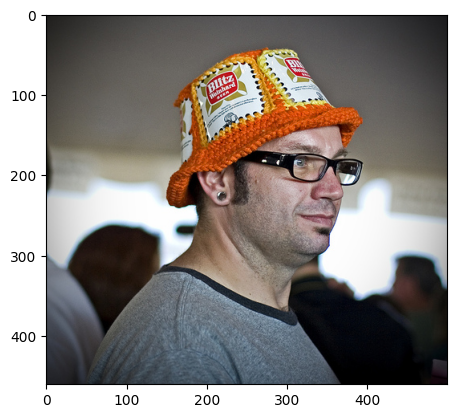

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
image_path = os.path.join(os.getcwd(), 'dataset', 'images', 'Flicker8k_Dataset', '1007129816_e794419615.jpg')

file = cv2.imread(image_path)


plt.imshow(cv2.cvtColor(file, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
print(infer(file))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


['menus', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial', 'interracial']
None
